# Sarcasm detection - MAIN CAS, modules text analytics and big data, Rita Fleer

This script only shows the output from the Bert model training because it stoped working in the other script for some unknown reason. It cannot be run on a stand-alone basis.

# BERT

In [45]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [46]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks, all_segments= [], [], []
    for doc in docs:
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids) # [1,1,1.....] # 500 ones
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        segments = [0] * max_seq_length # [0,0,0...] # 500 zeros
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)
        
    encoded = np.array([all_ids, all_masks, all_segments])
    
    return encoded

In [47]:
MAX_SEQ_LENGTH = 20

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")

train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer, 
                                                                                               train_hl, 
                                                                                               max_seq_length=MAX_SEQ_LENGTH)

val_features_ids, val_features_masks, val_features_segments = create_bert_input_features(tokenizer, 
                                                                                         val_hl, 
                                                                                         max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape, train_features_segments.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape, val_features_segments.shape)

Train Features: (23086, 20) (23086, 20) (23086, 20)
Val Features: (2566, 20) (2566, 20) (2566, 20)


In [48]:
#build the model

inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_input_ids (InputLayer  [(None, 20)]                 0         []                            
 )                                                                                                
                                                                                                  
 bert_input_masks (InputLay  [(None, 20)]                 0         []                            
 er)                                                                                              
                                                                                                  
 bert_segment_ids (InputLay  [(None, 20)]                 0         []                            
 er)                                                                                          

In [49]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)
history = model.fit([train_features_ids, 
           train_features_masks, 
           train_features_segments], train_l, 
          validation_data=([val_features_ids, 
                            val_features_masks, 
                            val_features_segments], val_l),
          epochs=15, 
          batch_size=32, 
          callbacks=[es],
          shuffle=True,
          verbose=1)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
722/722 [==============================] - ETA: 0s - loss: 0.3156 - accuracy: 0.8659WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fa943b53d80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set th

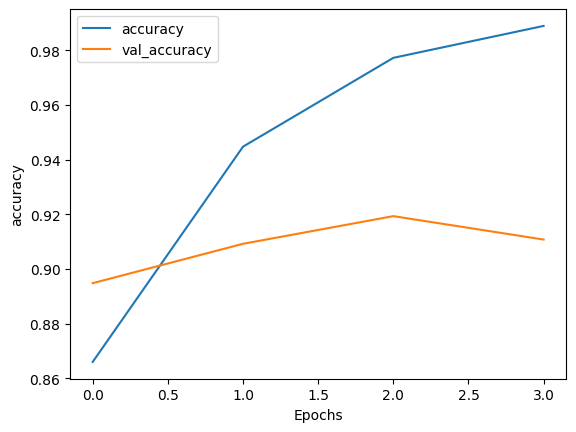

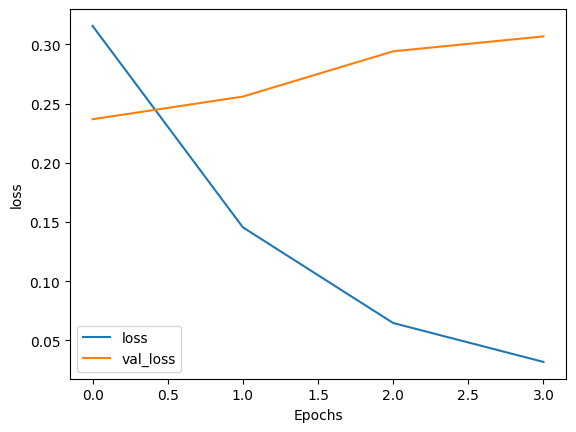

In [50]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [51]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer, 
                                                                                            test_hl, 
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Test Features: (2851, 20) (2851, 20) (2851, 20)


In [56]:

bert_predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([test_features_ids, 
                                            test_features_masks, 
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_l, bert_predictions)*100))
print(classification_report(test_l, bert_predictions))
pd.DataFrame(confusion_matrix(test_l, bert_predictions))

Accuracy: 90.18%
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1516
           1       0.84      0.97      0.90      1335

    accuracy                           0.90      2851
   macro avg       0.91      0.91      0.90      2851
weighted avg       0.91      0.90      0.90      2851



,0,1
0,1276,240
1,40,1295


In [57]:
pred = model.predict([test_features_ids, test_features_masks, test_features_segments], verbose=0).ravel()


In [58]:
# Store all test predictions in data frame
bertdf_predictions = pd.DataFrame()
bertdf_predictions['headline'] = np.array(test_hl).tolist()
bertdf_predictions['True label'] = np.array(test_l).tolist()
bertdf_predictions['bert'] = np.array([int(p) for p in bert_predictions]).tolist()
bertdf_predictions['bert prob'] = pred.flatten().tolist()
bertdf_predictions

,headline,True label,bert,bert prob
0,somali pirates free asian sailors after years ...,0,0,0.478111
1,coworker has that excuse that is going around,1,1,0.989332
2,praia de iracema is the place you should have ...,0,0,0.006333
3,women reveal the real purpose of workout clothes,0,0,0.359706
4,american politics in moral freefall,0,0,0.020327
...,...,...,...,...
2846,republican congressman the best reason to vote...,0,0,0.356458
2847,walking dead writers regret naming every singl...,1,1,0.985304
2848,that guy from that one show not looking so hot,1,1,0.983494
2849,an open letter to caitlyn jenner,0,0,0.002853


In [59]:
bertdf_predictions.to_csv('bert_predictions.csv', index=True, mode='w')